# 四种天气图片的分类、预训练网络RESNET与模型微调

## 微调

**微调：**   
在预训练模型的基础上，针对特定任务进行训练，调整模型参数，使其更适合特定任务。  
共同训练新添加的分类器层（全连接层）和部分或全部卷积层。  
只有分类器已经训练好了，才能训练卷积层。  
新训练卷积层时，通常训练靠近输出层的卷积层。  

**微调步骤：**
1. 加载预训练模型
2. 冻结预训练模型卷积层的所有参数，使其不参与训练
3. 修改或添加新的分类器层，并训练所有参数
4. 解冻部分卷积层，继续训练
5. 重复步骤4，直到模型性能满足要求

## 导入库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import os

## 读取图片

In [2]:
from torchvision import transforms

# 定义数据增强方法
train_transform = transforms.Compose([
    transforms.Resize(232),                       # 将图片缩放到232
    transforms.RandomCrop(224),                   # 随机裁剪224
    transforms.RandomHorizontalFlip(),            # 随机水平翻转，默认概率为0.5
    transforms.RandomRotation(0.2),               # 随机旋转0.2弧度
    transforms.ColorJitter(brightness=0.5),       # 亮度调整
    transforms.ColorJitter(contrast=0.5),         # 对比度调整
    transforms.ToTensor(),                        # 将图片转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])      # 将图片的每个通道的像素值减去均值，再除以标准差，使像素值均值为0，标准差为1
])

# 测试集不需要数据增强
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),                # 将图片缩放到224, 224（VGG卷积深度较深，输入图片大小不能过小）
    transforms.ToTensor(),                        # 将图片转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])      # 将图片的每个通道的像素值减去均值，再除以标准差，使像素值均值为0，标准差为1
])

In [3]:
base_dir = r'./dataset/4weather'
train_dir = os.path.join(base_dir , 'train')
test_dir = os.path.join(base_dir , 'test')
# 读取训练集和测试集的图片
train_ds = torchvision.datasets.ImageFolder(
               train_dir,
               transform=train_transform
)
test_ds = torchvision.datasets.ImageFolder(
               test_dir,
               transform=test_transform
)

## 加载和查看数据

In [4]:
# 加载数据集，划分批次
BATCHSIZE = 32
train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BATCHSIZE,
                                       shuffle=True
)
test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BATCHSIZE,
)

## 实例化RESNET101模型

In [ ]:
# model = torchvision.models.resnet101(weights='IMAGENET1K_V1')
model = torchvision.models.resnet101(weights='IMAGENET1K_V2')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
# 冻结卷积层
for param in model.parameters():
    param.requires_grad = False

# 修改全连接层
in_f = model.fc.in_features
model.fc = nn.Linear(in_f, 4)   # 替换全连接层，输出为4个类别，默认parameters()为True，即需要训练
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 训练模型

In [7]:
# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model.to(device) # 将已实例化的模型移动到GPU上

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
opt = torch.optim.Adam(model.fc.parameters(), lr=0.001) # 优化器，Adam优化器，学习率为0.0001

# 学习率调整器
from torch.optim import lr_scheduler

# # 手动调整学习率
# for param_group in opt.param_groups:
#     print(param_group['lr'])
#     param_group['lr'] *= 0.9

exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=10, gamma=0.5) # 每隔10个epoch，学习率衰减为原来的0.5倍

# lr_scheduler.MultiStepLR(opt, milestones=[5, 10, 15, 20], gamma=0.5) # 每隔5个epoch，学习率衰减为原来的0.1倍
# lr_scheduler.ExponentialLR(opt, gamma=0.5) # 每个epoch，学习率衰减为原来的0.5倍
epochs = 30

In [8]:
# 通用训练模板，输入模型、训练数据、测试数据，返回loss和acc变化
# 训练函数
def train(train_dl, model, loss_fn, opt):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率

    for x, y in train_dl: # 遍历数据集
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    exp_lr_scheduler.step() # 学习率调整
    train_loss /= num_batches # 计算平均损失
    train_acc /= size # 计算平均准确率

    return train_loss, train_acc

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl: # 遍历数据集
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    test_loss /= num_batches # 计算平均损失
    test_acc /= size # 计算平均准确率

    return test_loss, test_acc

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        model.train() # 设置模型为训练模式，启用dropout层
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt)
        model.eval() # 设置模型为评估预测模式，禁用dropout层
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

    return train_loss, train_acc, test_loss, test_acc

# 训练
train_loss, train_acc, test_loss, test_acc = fit(epochs, model, train_dl, test_dl, loss_fn, opt)

Epoch: 0, Train Loss: 0.9365, Train Acc: 67.89%, Test Loss: 0.6015, Test Acc: 88.44%
Epoch: 1, Train Loss: 0.4766, Train Acc: 90.56%, Test Loss: 0.3896, Test Acc: 92.44%
Epoch: 2, Train Loss: 0.3738, Train Acc: 91.56%, Test Loss: 0.3006, Test Acc: 93.33%
Epoch: 3, Train Loss: 0.3251, Train Acc: 92.44%, Test Loss: 0.2920, Test Acc: 92.44%
Epoch: 4, Train Loss: 0.2593, Train Acc: 94.56%, Test Loss: 0.2377, Test Acc: 93.78%
Epoch: 5, Train Loss: 0.2353, Train Acc: 94.56%, Test Loss: 0.2210, Test Acc: 94.22%
Epoch: 6, Train Loss: 0.2527, Train Acc: 93.89%, Test Loss: 0.2181, Test Acc: 94.22%
Epoch: 7, Train Loss: 0.2389, Train Acc: 94.22%, Test Loss: 0.1837, Test Acc: 94.22%
Epoch: 8, Train Loss: 0.2070, Train Acc: 94.67%, Test Loss: 0.1779, Test Acc: 93.78%
Epoch: 9, Train Loss: 0.1781, Train Acc: 95.22%, Test Loss: 0.1699, Test Acc: 94.22%
Epoch: 10, Train Loss: 0.1802, Train Acc: 95.00%, Test Loss: 0.1632, Test Acc: 93.33%
Epoch: 11, Train Loss: 0.1655, Train Acc: 96.22%, Test Loss: 0.1

## 可视化训练结果

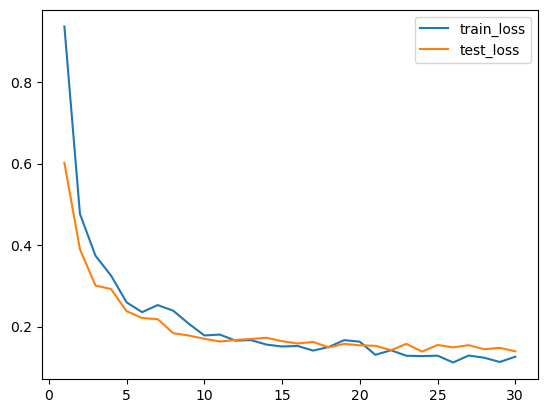

In [9]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

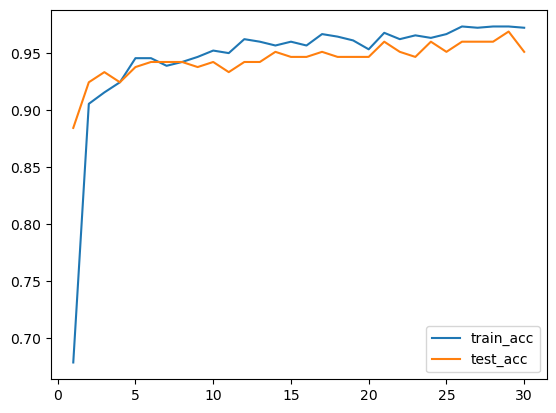

In [10]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()